# Учим VGG-Unet-with-crop по 3-м каналам с BN на входе

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.3):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


KTF.set_session(get_session())

Using TensorFlow backend.


In [3]:
!nvidia-smi

Tue Nov 28 12:05:47 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    68W / 149W |   3519MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import os
import re
import json

import unet
import dataset
import train_test_loader
import learning_experiment as lexperiment

import datetime

from shutil import copyfile

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
experiment23 = lexperiment.LearningExperiment('./experiments/2017-11-26 10:14:48.816151')

In [7]:
data_set = experiment23.data_set

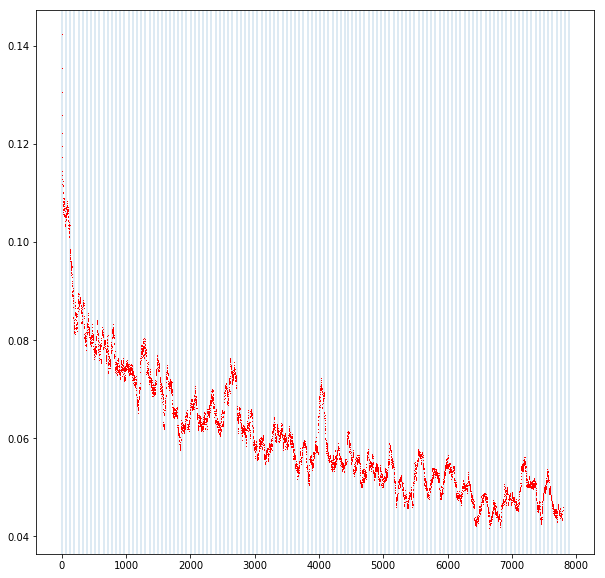

In [8]:
plt.figure(figsize=(10,10))
ws = 101
lexperiment.plot_loss(experiment23.loss_history(), window_size=ws, color='r')

In [9]:
net_ = unet.VGGUnetModelWithCrop(N=40)

In [10]:
import numpy as np

def predict(net, X):
    X_exp = lexperiment.expand_with_mirrors(X, 104)
    xs = [0, 214]
    Y = np.ones((650,650),dtype='float32')
    Yn = np.zeros((650,650),dtype='float32')
    
    batch = []
    for i in xs:
        for j in xs:
            crop = X_exp[i:i+644, j:j+644, :]
            batch.append(crop)
    
    batch = np.array(batch)
    
    y_pred = net.predict(batch)
    
    n = 0
    for i in xs:
        for j in xs:
            Y[i:i+436,j:j+436] *= y_pred[n,:,:,0]
            Yn[i:i+436,j:j+436] += 1.0
            n += 1
            
    return np.power(Y, 1.0/Yn)

In [11]:
experiment23.epochs()

[0, 10, 20, 31, 41, 51, 61, 72, 82, 92, 102, 112, 117, 118, 119, 120, 121]

In [12]:
net = experiment23.load_net()
net_.set_weights(net.get_weights())

In [13]:
im_id = 'img1779' # data_set.test_ids[30]
X = data_set.get_ndarray(im_id)
Y_true = data_set.get_mask(im_id)
%time Y_pred = predict(net_, X)

CPU times: user 6.61 s, sys: 1.79 s, total: 8.4 s
Wall time: 8.35 s


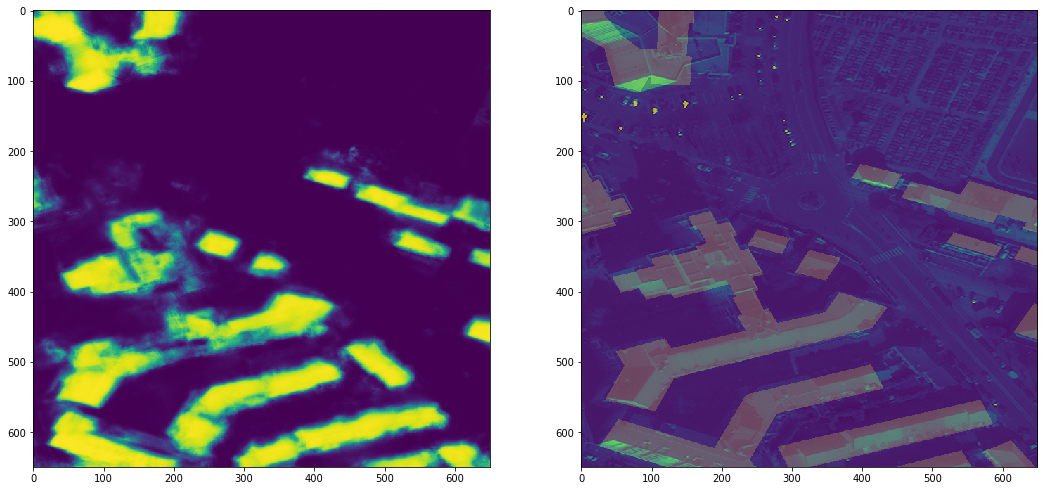

In [14]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
#plt.imshow(X[:,:,0])
plt.imshow(Y_pred)
#plt.imshow(Y_true, alpha=0.2)

plt.subplot(1,2,2)
plt.imshow(X[:,:,0])
plt.imshow(Y_true, alpha=0.2)

In [16]:
for n,img_id in enumerate(data_set.test_ids):
    print ("n: %d, img_id: %s" % (n, img_id))
    X = data_set.get_ndarray(img_id)
    Y = predict(net_, X)
    Y.dump('./predict/' + img_id)

n: 0, img_id: img1553
n: 1, img_id: img1410
n: 2, img_id: img1226
n: 3, img_id: img492
n: 4, img_id: img1289
n: 5, img_id: img1706
n: 6, img_id: img821
n: 7, img_id: img336
n: 8, img_id: img1262
n: 9, img_id: img1751
n: 10, img_id: img119
n: 11, img_id: img98
n: 12, img_id: img624
n: 13, img_id: img472
n: 14, img_id: img387
n: 15, img_id: img136
n: 16, img_id: img1629
n: 17, img_id: img543
n: 18, img_id: img1617
n: 19, img_id: img121
n: 20, img_id: img293
n: 21, img_id: img234
n: 22, img_id: img95
n: 23, img_id: img271
n: 24, img_id: img1224
n: 25, img_id: img282
n: 26, img_id: img1159
n: 27, img_id: img204
n: 28, img_id: img1201
n: 29, img_id: img323
n: 30, img_id: img1176
n: 31, img_id: img491
n: 32, img_id: img490
n: 33, img_id: img1800
n: 34, img_id: img228
n: 35, img_id: img690
n: 36, img_id: img815
n: 37, img_id: img1069
n: 38, img_id: img819
n: 39, img_id: img1338
n: 40, img_id: img1206
n: 41, img_id: img1801
n: 42, img_id: img135
n: 43, img_id: img1540
n: 44, img_id: img793
n: 

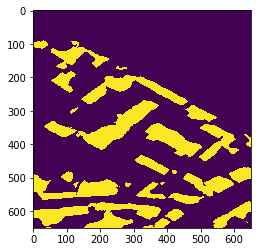

In [20]:
plt.imshow(np.load('./predict/img203') > 0.7)